# Baseline model

Ako baseline model sme použili regresnú neurónovú sieť, skladajúcu sa zo 4 DENSE vrstiev(16-8-4-4) s aktivačnou funkciou RELU. Po vytvorení tohto modelu sme sa rozhodli vytvoriť iný baseline model, keďže výsledky pôvodne plánovaného modelu sme vyhodnotili ako nedostačné.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext tensorboard

import datetime
import os
import sys
sys.path.append('..')

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from matplotlib import pyplot


In [2]:
def timestamp():
    return datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

Načítanie hodnôt z vopred pripraveného datasetu 1.

In [64]:
testx = np.genfromtxt('./datasets/dataSet1TestX1.csv', delimiter=',')[1:]
testy = np.genfromtxt('./datasets/dataSet1TestY1.csv', delimiter=',')

trainx = np.genfromtxt('./datasets/dataSet1TrainX1.csv', delimiter=',')[1:]
trainy = np.genfromtxt('./datasets/dataSet1TrainY1.csv', delimiter=',')

Načítanie hodnôt z vopred pripraveného datasetu 2.

In [90]:
testx = np.genfromtxt('./datasets/dataSet2TestX.csv', delimiter=',')[1:]
testy = np.genfromtxt('./datasets/dataSet2TestY.csv', delimiter=',')

trainx = np.genfromtxt('./datasets/dataSet2TrainX.csv', delimiter=',')[1:]
trainy = np.genfromtxt('./datasets/dataSet2TrainY.csv', delimiter=',')

Načítanie hodnôt z vopred pripraveného datasetu 3.

In [113]:
testx = np.genfromtxt('./datasets/dataSet3TestX.csv', delimiter=',')[1:]
testy = np.genfromtxt('./datasets/dataSet3TestY.csv', delimiter=',')

trainx = np.genfromtxt('./datasets/dataSet3TrainX.csv', delimiter=',')[1:]
trainy = np.genfromtxt('./datasets/dataSet3TrainY.csv', delimiter=',')

In [3]:
testx = np.genfromtxt('./datasets/dataSet4TestX.csv', delimiter=',')[1:]
testy = np.genfromtxt('./datasets/dataSet4TestY.csv', delimiter=',')

trainx = np.genfromtxt('./datasets/dataSet4TrainX.csv', delimiter=',')[1:]
trainy = np.genfromtxt('./datasets/dataSet4TrainY.csv', delimiter=',')

In [3]:
testx = np.genfromtxt('./datasets/dataSet5TestX.csv', delimiter=',')[1:]
testy = np.genfromtxt('./datasets/dataSet5TestY.csv', delimiter=',')

trainx = np.genfromtxt('./datasets/dataSet5TrainX.csv', delimiter=',')[1:]
trainy = np.genfromtxt('./datasets/dataSet5TrainY.csv', delimiter=',')

Prvý model s  DENSE vrstvami.

In [4]:
def identity_block(X,width):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    X_shortcut = X
    
    # Second component of main path (≈3 lines)
    X = keras.layers.Dense(width, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(X)
    X = keras.layers.Dense(width, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(X)
    X = keras.layers.Dense(width, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(X)
    X = keras.layers.Dense(width, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(X)   
#     X = keras.layers.Dense(width, activation='relu')(X)
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)
    
    return X


In [5]:
def ResNetBH(input_shape=(25), classes=6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = keras.Input(input_shape)
    
    # Stage 1
    X = keras.layers.Dense(256, activation='relu')(X_input)
    # Zero-Padding
    X = keras.layers.Dense(128, activation='relu')(X)


    # Stage 3 (≈4 lines)
    X = identity_block(X,128)
    X = identity_block(X,128)
    X = keras.layers.Dropout(0.1)(X) 
#     X = identity_block(X,128)
    X = keras.layers.Dense(64, activation='relu')(X) 
    X = identity_block(X,64)
    X = identity_block(X,64)
    X = keras.layers.Dropout(0.1)(X) 
#     X = identity_block(X,64)
    X = keras.layers.Dense(32, activation='relu')(X) 
    X = identity_block(X,32)
    X = identity_block(X,32)
#     X = identity_block(X,32)

    # output layer
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(classes, activation='softmax', name='fc' + str(classes))(X)
    
    
    # Create model
    model = keras.models.Model(inputs = X_input, outputs = X, name='ResNetBH')

    return model

In [7]:

model = ResNetBH(input_shape = (62), classes = 18)

model.compile(loss='sparse_categorical_crossentropy',  
#               optimizer=keras.optimizers.SGD(lr=0.005),
              optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
#               optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['sparse_categorical_accuracy'])

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=os.path.join("logs", timestamp()),
    histogram_freq=1)

history = model.fit(trainx, trainy,
          validation_data=(testx, testy),
          shuffle=True,
          batch_size=128,
          epochs=300,
          callbacks=[tensorboard_callback],
          verbose=1);

Train on 9013 samples, validate on 2253 samples
Epoch 1/300
9013/9013 [==============================] - 4s 422us/sample - loss: 19.6051 - sparse_categorical_accuracy: 0.1916 - val_loss: 18.4965 - val_sparse_categorical_accuracy: 0.2561
Epoch 2/300
9013/9013 [==============================] - 1s 76us/sample - loss: 17.6818 - sparse_categorical_accuracy: 0.2190 - val_loss: 16.7859 - val_sparse_categorical_accuracy: 0.2490
Epoch 3/300
9013/9013 [==============================] - 1s 73us/sample - loss: 16.0891 - sparse_categorical_accuracy: 0.2202 - val_loss: 15.3139 - val_sparse_categorical_accuracy: 0.2539
Epoch 4/300
9013/9013 [==============================] - 1s 76us/sample - loss: 14.6908 - sparse_categorical_accuracy: 0.2222 - val_loss: 13.9850 - val_sparse_categorical_accuracy: 0.2534
Epoch 5/300
9013/9013 [==============================] - 1s 76us/sample - loss: 13.4280 - sparse_categorical_accuracy: 0.2236 - val_loss: 12.7883 - val_sparse_categorical_accuracy: 0.2521
Epoch 6/300

9013/9013 [==============================] - 1s 102us/sample - loss: 2.3288 - sparse_categorical_accuracy: 0.2534 - val_loss: 2.3727 - val_sparse_categorical_accuracy: 0.2450
Epoch 45/300
9013/9013 [==============================] - 1s 92us/sample - loss: 2.3104 - sparse_categorical_accuracy: 0.2530 - val_loss: 2.3554 - val_sparse_categorical_accuracy: 0.2477
Epoch 46/300
9013/9013 [==============================] - 1s 94us/sample - loss: 2.2918 - sparse_categorical_accuracy: 0.2564 - val_loss: 2.3429 - val_sparse_categorical_accuracy: 0.2472
Epoch 47/300
9013/9013 [==============================] - 1s 97us/sample - loss: 2.2743 - sparse_categorical_accuracy: 0.2594 - val_loss: 2.3290 - val_sparse_categorical_accuracy: 0.2459
Epoch 48/300
9013/9013 [==============================] - 1s 97us/sample - loss: 2.2582 - sparse_categorical_accuracy: 0.2641 - val_loss: 2.3202 - val_sparse_categorical_accuracy: 0.2379
Epoch 49/300
9013/9013 [==============================] - 1s 107us/sample - l

Epoch 88/300
9013/9013 [==============================] - 1s 76us/sample - loss: 1.9291 - sparse_categorical_accuracy: 0.3190 - val_loss: 2.1643 - val_sparse_categorical_accuracy: 0.2321
Epoch 89/300
9013/9013 [==============================] - 1s 75us/sample - loss: 1.9313 - sparse_categorical_accuracy: 0.3188 - val_loss: 2.1658 - val_sparse_categorical_accuracy: 0.2281
Epoch 90/300
9013/9013 [==============================] - 1s 84us/sample - loss: 1.9243 - sparse_categorical_accuracy: 0.3202 - val_loss: 2.1578 - val_sparse_categorical_accuracy: 0.2299
Epoch 91/300
9013/9013 [==============================] - 1s 75us/sample - loss: 1.9156 - sparse_categorical_accuracy: 0.3277 - val_loss: 2.1609 - val_sparse_categorical_accuracy: 0.2286
Epoch 92/300
9013/9013 [==============================] - 1s 83us/sample - loss: 1.9080 - sparse_categorical_accuracy: 0.3235 - val_loss: 2.1609 - val_sparse_categorical_accuracy: 0.2357
Epoch 93/300
9013/9013 [==============================] - 1s 78us

9013/9013 [==============================] - 1s 83us/sample - loss: 1.5976 - sparse_categorical_accuracy: 0.4283 - val_loss: 2.1263 - val_sparse_categorical_accuracy: 0.2490
Epoch 132/300
9013/9013 [==============================] - 1s 82us/sample - loss: 1.5879 - sparse_categorical_accuracy: 0.4284 - val_loss: 2.1171 - val_sparse_categorical_accuracy: 0.2565
Epoch 133/300
9013/9013 [==============================] - 1s 82us/sample - loss: 1.5866 - sparse_categorical_accuracy: 0.4312 - val_loss: 2.1150 - val_sparse_categorical_accuracy: 0.2401
Epoch 134/300
9013/9013 [==============================] - 1s 82us/sample - loss: 1.5919 - sparse_categorical_accuracy: 0.4295 - val_loss: 2.1162 - val_sparse_categorical_accuracy: 0.2583
Epoch 135/300
9013/9013 [==============================] - 1s 82us/sample - loss: 1.5698 - sparse_categorical_accuracy: 0.4325 - val_loss: 2.1080 - val_sparse_categorical_accuracy: 0.2605
Epoch 136/300
9013/9013 [==============================] - 1s 82us/sample 

Epoch 175/300
9013/9013 [==============================] - 1s 83us/sample - loss: 1.2918 - sparse_categorical_accuracy: 0.5179 - val_loss: 2.1170 - val_sparse_categorical_accuracy: 0.2818
Epoch 176/300
9013/9013 [==============================] - 1s 82us/sample - loss: 1.2806 - sparse_categorical_accuracy: 0.5301 - val_loss: 2.0578 - val_sparse_categorical_accuracy: 0.2805
Epoch 177/300
9013/9013 [==============================] - 1s 82us/sample - loss: 1.2804 - sparse_categorical_accuracy: 0.5297 - val_loss: 2.0771 - val_sparse_categorical_accuracy: 0.2805
Epoch 178/300
9013/9013 [==============================] - 1s 82us/sample - loss: 1.2850 - sparse_categorical_accuracy: 0.5265 - val_loss: 2.0772 - val_sparse_categorical_accuracy: 0.2796
Epoch 179/300
9013/9013 [==============================] - 1s 82us/sample - loss: 1.2707 - sparse_categorical_accuracy: 0.5309 - val_loss: 2.0730 - val_sparse_categorical_accuracy: 0.2779
Epoch 180/300
9013/9013 [==============================] - 1

9013/9013 [==============================] - 1s 76us/sample - loss: 1.0883 - sparse_categorical_accuracy: 0.5957 - val_loss: 2.1661 - val_sparse_categorical_accuracy: 0.2765
Epoch 219/300
9013/9013 [==============================] - 1s 75us/sample - loss: 1.0776 - sparse_categorical_accuracy: 0.6036 - val_loss: 2.1392 - val_sparse_categorical_accuracy: 0.2876
Epoch 220/300
9013/9013 [==============================] - 1s 81us/sample - loss: 1.0774 - sparse_categorical_accuracy: 0.6068 - val_loss: 2.1441 - val_sparse_categorical_accuracy: 0.2872
Epoch 221/300
9013/9013 [==============================] - 1s 75us/sample - loss: 1.0680 - sparse_categorical_accuracy: 0.6058 - val_loss: 2.1516 - val_sparse_categorical_accuracy: 0.2885
Epoch 222/300
9013/9013 [==============================] - 1s 74us/sample - loss: 1.0689 - sparse_categorical_accuracy: 0.6045 - val_loss: 2.1359 - val_sparse_categorical_accuracy: 0.2929
Epoch 223/300
9013/9013 [==============================] - 1s 77us/sample 

Epoch 262/300
9013/9013 [==============================] - 1s 74us/sample - loss: 0.9314 - sparse_categorical_accuracy: 0.6563 - val_loss: 2.2769 - val_sparse_categorical_accuracy: 0.2952
Epoch 263/300
9013/9013 [==============================] - 1s 74us/sample - loss: 0.9214 - sparse_categorical_accuracy: 0.6599 - val_loss: 2.3102 - val_sparse_categorical_accuracy: 0.2836
Epoch 264/300
9013/9013 [==============================] - 1s 75us/sample - loss: 0.9152 - sparse_categorical_accuracy: 0.6604 - val_loss: 2.3066 - val_sparse_categorical_accuracy: 0.2934
Epoch 265/300
9013/9013 [==============================] - 1s 74us/sample - loss: 0.9120 - sparse_categorical_accuracy: 0.6634 - val_loss: 2.2935 - val_sparse_categorical_accuracy: 0.2889
Epoch 266/300
9013/9013 [==============================] - 1s 74us/sample - loss: 0.9138 - sparse_categorical_accuracy: 0.6634 - val_loss: 2.2964 - val_sparse_categorical_accuracy: 0.2978
Epoch 267/300
9013/9013 [==============================] - 1

In [61]:
values = model.predict(testx[:20])

In [62]:
print(np.argmax(values,axis=1))

[7 5 5 7 5 5 7 5 7 3 3 6 7 7 7 9 5 7 5 3]


In [63]:
testy[:20]

array([ 7.,  3.,  5.,  7.,  6.,  4.,  8.,  7.,  8.,  2.,  3.,  7.,  9.,
        9.,  7., 10.,  5.,  7.,  8.,  1.])

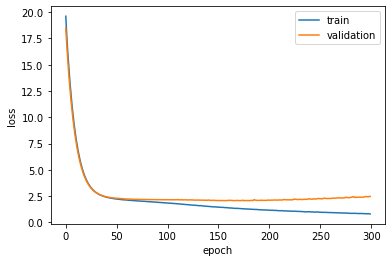

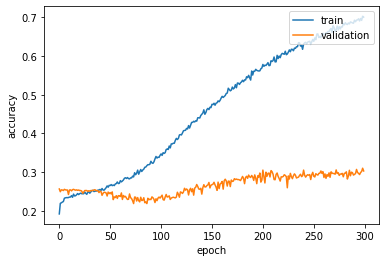

In [8]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

pyplot.plot(history.history['sparse_categorical_accuracy'])
pyplot.plot(history.history['val_sparse_categorical_accuracy'])
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [26]:
model = tf.keras.Sequential()
model.add(keras.layers.Embedding(1000, output_dim=100, input_length=23))


# Add a LSTM layer with 128 internal units.
# model.add(keras.layers.GRU(32))
# model.add(keras.layers.Dense(16, activation='relu'))
# model.add(keras.layers.Dense(8, activation='relu'))
# model.add(keras.layers.Dense(4, activation='relu'))
# model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Dense(1, activation='relu'))

# model.compile(loss='mean_squared_error',  
#               optimizer=keras.optimizers.SGD(lr=0.03,  nesterov=True),
#               metrics=['MAE'])

# history = model.fit(trainx, trainy,
#           validation_data=(testx, testy),
#           shuffle=True,
#           batch_size=128,
#           epochs=30);

input_array = np.random.randint(1000, size=(200, 23))

model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array.shape)

(200, 23, 100)


Po tomto modeli sme sa rozhodli, že vytvoríme klasifikačnú rekurentnú neurónovú sieť(RNN). Model sme sa snažili priradiť do jednej zo 16 klasifikačných tried, pričom každá trieda symbolizovala počet gólov(v prípade, že mal byť výsledok 7 gólov a sieť ho odhadla správne, tak je najvyššia hodnota pravdepodobnost na indexe číslo 6 vo výslednom vektore). 

- Na trénovanie sme použili LSTM vrstvu, ktorú sme neskôr kvôli rýchlejšiemu trénovaniu nahradili GRU vrstvou. 
- Po tejto vrstve sme použili dense vrstvu so softmax aktiváciou, SGD optimizerom a sparse_categorical_crossentropy loss funkciou. 

Neskôr sme pridávali rôzne vrstvy, ktoré však väčšinou nemali veľký vplyv na výsledok. S nami otestovaných sietí boli najlepšie tieto:

Embedding(input_dim=64, output_dim=1)
- GRU(32) ->
- Dense(16, activation='relu') ->
- Dense(16, activation='softmax')

hyperparametre:
- SGD(lr=0.01, momentum=0.65, nesterov=True)
- loss='sparse_categorical_crossentropy'
- metrics='sparse_categorical_accuracy'
- batch_size=128
 - epochs=25

In [52]:
model = tf.keras.Sequential()
# model.add(keras.layers.Embedding(64,  output_dim=100, input_length=25))

# Add a LSTM layer with 128 internal units.
# model.add(keras.layers.GRU(128))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',  
              optimizer=keras.optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=False),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(trainx, trainy,
          validation_data=(testx, testy),
          shuffle=True,
          batch_size=128,
          epochs=100);


values = model.predict(testx[:10])

Train on 8491 samples, validate on 1358 samples
Epoch 1/100
8491/8491 [==============================] - 1s 93us/sample - loss: 2.2521 - sparse_categorical_accuracy: 0.2231 - val_loss: 2.2149 - val_sparse_categorical_accuracy: 0.1642
Epoch 2/100
8491/8491 [==============================] - 0s 27us/sample - loss: 2.1502 - sparse_categorical_accuracy: 0.2451 - val_loss: 2.2081 - val_sparse_categorical_accuracy: 0.2172
Epoch 3/100
8491/8491 [==============================] - 0s 33us/sample - loss: 2.1425 - sparse_categorical_accuracy: 0.2460 - val_loss: 2.2044 - val_sparse_categorical_accuracy: 0.2172
Epoch 4/100
8491/8491 [==============================] - 1s 61us/sample - loss: 2.1354 - sparse_categorical_accuracy: 0.2489 - val_loss: 2.2026 - val_sparse_categorical_accuracy: 0.2172
Epoch 5/100
8491/8491 [==============================] - 1s 60us/sample - loss: 2.1277 - sparse_categorical_accuracy: 0.2496 - val_loss: 2.2158 - val_sparse_categorical_accuracy: 0.2172
Epoch 6/100
8491/8491 

Epoch 88/100
8491/8491 [==============================] - 1s 76us/sample - loss: 2.0627 - sparse_categorical_accuracy: 0.2603 - val_loss: 2.2634 - val_sparse_categorical_accuracy: 0.2128
Epoch 89/100
8491/8491 [==============================] - 1s 76us/sample - loss: 2.0540 - sparse_categorical_accuracy: 0.2665 - val_loss: 2.2747 - val_sparse_categorical_accuracy: 0.2113
Epoch 90/100
8491/8491 [==============================] - 1s 74us/sample - loss: 2.0629 - sparse_categorical_accuracy: 0.2615 - val_loss: 2.2834 - val_sparse_categorical_accuracy: 0.2216
Epoch 91/100
8491/8491 [==============================] - 1s 73us/sample - loss: 2.0554 - sparse_categorical_accuracy: 0.2631 - val_loss: 2.2663 - val_sparse_categorical_accuracy: 0.2121
Epoch 92/100
8491/8491 [==============================] - 1s 69us/sample - loss: 2.0523 - sparse_categorical_accuracy: 0.2649 - val_loss: 2.3181 - val_sparse_categorical_accuracy: 0.2158
Epoch 93/100
8491/8491 [==============================] - 1s 72us

In [68]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

pyplot.plot(history.history['sparse_categorical_accuracy'])
pyplot.plot(history.history['val_sparse_categorical_accuracy'])
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

NameError: name 'history' is not defined

Embedding(input_dim=64, output_dim=1)
- GRU(32) ->
- Dropout(0.2) ->
- Dense(16, activation='softmax')

Hyperparametre:
- SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=False),
- loss='sparse_categorical_crossentropy'
- metrics='sparse_categorical_accuracy'
- batch_size=128
 - epochs=30

In [8]:
model = tf.keras.Sequential()
model.add(keras.layers.Embedding(input_dim=64, output_dim=1))

# Add a LSTM layer with 128 internal units.
model.add(keras.layers.GRU(32))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',  
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.65, nesterov=True),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(trainx, trainy,
          validation_data=(testx, testy),
          shuffle=True,
          batch_size=128,
          epochs=25);

values = model.predict(testx[:10])

Train on 8491 samples, validate on 1358 samples
Epoch 1/25
8491/8491 [==============================] - 4s 424us/sample - loss: 2.6339 - sparse_categorical_accuracy: 0.2306 - val_loss: 2.5064 - val_sparse_categorical_accuracy: 0.2172
Epoch 2/25
8491/8491 [==============================] - 1s 132us/sample - loss: 2.3809 - sparse_categorical_accuracy: 0.2434 - val_loss: 2.3233 - val_sparse_categorical_accuracy: 0.2172
Epoch 3/25
8491/8491 [==============================] - 1s 118us/sample - loss: 2.2704 - sparse_categorical_accuracy: 0.2331 - val_loss: 2.2552 - val_sparse_categorical_accuracy: 0.2172
Epoch 4/25
8491/8491 [==============================] - 1s 119us/sample - loss: 2.2167 - sparse_categorical_accuracy: 0.2342 - val_loss: 2.2258 - val_sparse_categorical_accuracy: 0.2172
Epoch 5/25
8491/8491 [==============================] - 1s 121us/sample - loss: 2.1934 - sparse_categorical_accuracy: 0.2388 - val_loss: 2.2133 - val_sparse_categorical_accuracy: 0.2172
Epoch 6/25
8491/8491 [

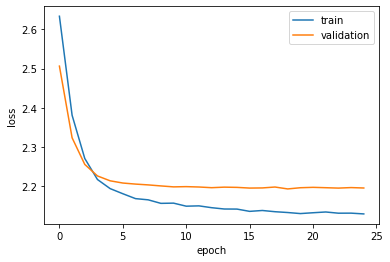

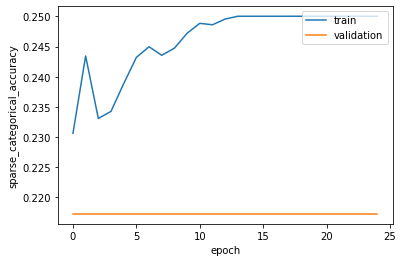

In [9]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

pyplot.plot(history.history['sparse_categorical_accuracy'])
pyplot.plot(history.history['val_sparse_categorical_accuracy'])
pyplot.ylabel('sparse_categorical_accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()


In [19]:
 %tensorboard --logdir logs --bind_all

Sparse_categorical_accuracy bola v obidvoch modeloch na hranici **25%**, pričom aj pri zmene hyperparametrov a architektúry nebolo možné dosiahnuť vyššiu presnosť. Vyššie popísané architektúry boli použité z toho dôvodu, lebo dokázali najlepšie minimalizovať loss funkciu(**na hodnotu 2**), pričom pri ostatných architektúrach bola táto hodnota **2,7**. 